In [77]:
import pandas as pd
import numpy as np
import r2pipe as r2
from tqdm import tqdm

BYTE_LENGTH = 2000
N_GRAM_1 = 2
N_GRAM_2 = 4
N_WAYS = 10
SEED = 7
NUM_EXAMPLES = 200
NUM_EXAMPLES_TEST = 30

# load dataset
DATASET_PATH = f"./dataset/malware_original_x86_64_byte_sequence{BYTE_LENGTH}_split.csv"
DATASET_FOLDER = "/home/mandy900619/data/Malware202403/"
CLUSTER_PATH = "./cluster_data/"
TSNE_PATH = "./pic/"
MODEL_PATH = "./models/"
LOG_PATH = "./logs/"
CPU_ARCH = "x86_64"   


### Distance Builder

In [78]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import numpy as np

class DistanceBuilder(object):

  """
  Build distance file for cluster
  """  

  def __init__(self):
    self.vectors = []

  def load_points(self, filename):
    '''
    Load all points from file(x dimension vectors)

    Args:
        filename : file's name that contains all points. Format is a vector one line, each dimension value split by blank space
    '''
    with open(filename, 'r') as fp:
      for line in fp:
        self.vectors.append(np.array(list(map(float, line.split('\t')[:])), dtype = np.float32))
    self.vectors = np.array(self.vectors, dtype = np.float32)


  def build_distance_file_for_cluster(self, distance_obj, filename):
    '''
    Save distance and index into file

    Args:
        distance_obj : distance.Distance object for compute the distance of two point
        filename     : file to save the result for cluster
    '''
    fo = open(filename, 'w')
    for i in range(len(self.vectors) - 1):
      for j in range(i, len(self.vectors)):
        fo.write(str(i + 1) + ' ' + str(j + 1) + ' ' + str(distance_obj.distance(self.vectors[i], self.vectors[j])) + '\n')
    fo.close()

In [80]:
from math import sqrt
from abc import ABCMeta, abstractmethod
import numpy as np
import numpy.linalg as linalg


class WrongVecError(Exception):
    '''
    Raised when an operation use empty or not same size vector.
    
    Attributes:
        value: error info
    '''
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        return repr(self.value)

class Distance():
  """
    abstract class, represent distance of two vector
    
    Attributes:
    """    

  __metaclass__ = ABCMeta
         
  @abstractmethod
  def distance(self, vec1, vec2):
    """
    Compute distance of two vector(one line numpy array)
    if you use scipy to store the sparse matrix, please use s.getrow(line_num).toarray() build the one dimensional array
    
    Args:
        vec1: the first line vector, an instance of array
        vec2: the second line vector, an instance of array
      
    Returns:
        the computed distance
    
    Raises:
        TypeError: if vec1 or vec2 is not numpy.ndarray and one line array
    """
    if not isinstance(vec1, np.ndarray) or not isinstance(vec2, np.ndarray):
      raise TypeError("type of vec1 or vec2 is not numpy.ndarray")
    if vec1.ndim is not 1 or vec2.ndim is not 1:
      raise WrongVecError("vec1 or vec2 is not one line array")
    if vec1.size != vec2.size:
      raise WrongVecError("vec1 or vec2 is not same size")    
    pass
  
class SqrtDistance(Distance):
  """
  Square distance
      
  a sub class of Distance
  """  

  def distance(self, vec1, vec2):
    """
    Compute distance of two vector by square distance
    """
    super(SqrtDistance, self).distance(vec1, vec2)      #super method
    vec=vec1-vec2
    return sqrt(sum([pow(item, 2) for item in vec]))

<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_1613416/874899000.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if vec1.ndim is not 1 or vec2.ndim is not 1:
/tmp/ipykernel_1613416/874899000.py:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if vec1.ndim is not 1 or vec2.ndim is not 1:


In [81]:
# test for one class
FAMILY = "camelot"
builder = DistanceBuilder()
builder.load_points(f'{CLUSTER_PATH}{CPU_ARCH}_{FAMILY}_train.txt')
builder.build_distance_file_for_cluster(SqrtDistance(), f'{CLUSTER_PATH}{CPU_ARCH}_{FAMILY}_train.dat')

### Choose Center

In [82]:
import logging
from plot import *
from cluster import *


def plot(data, auto_select_dc = False):
	logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
	dpcluster = DensityPeakCluster()
	distances, max_dis, min_dis, max_id, rho, rc = dpcluster.local_density(load_paperdata, data, auto_select_dc = auto_select_dc)
	delta, nneigh = min_distance(max_id, max_dis, distances, rho)
	plot_rho_delta(rho, delta)   #plot to choose the threthold

2024-07-02 13:40:43,211 : INFO : PROGRESS: load data
2024-07-02 13:40:43,248 : INFO : PROGRESS: load end
2024-07-02 13:40:43,248 : INFO : PROGRESS: select dc
2024-07-02 13:40:43,261 : INFO : PROGRESS: compute local density
2024-07-02 13:40:43,263 : INFO : PROGRESS: at index #20
2024-07-02 13:40:43,265 : INFO : PROGRESS: at index #40
2024-07-02 13:40:43,267 : INFO : PROGRESS: at index #60
2024-07-02 13:40:43,269 : INFO : PROGRESS: at index #80
2024-07-02 13:40:43,270 : INFO : PROGRESS: at index #100
2024-07-02 13:40:43,271 : INFO : PROGRESS: at index #120
2024-07-02 13:40:43,272 : INFO : PROGRESS: at index #140
2024-07-02 13:40:43,273 : INFO : PROGRESS: at index #160
2024-07-02 13:40:43,274 : INFO : PROGRESS: at index #180
2024-07-02 13:40:43,274 : INFO : PROGRESS: compute min distance to nearest higher density neigh
2024-07-02 13:40:43,275 : INFO : PROGRESS: at index #20
2024-07-02 13:40:43,276 : INFO : PROGRESS: at index #40
2024-07-02 13:40:43,276 : INFO : PROGRESS: at index #60
2024

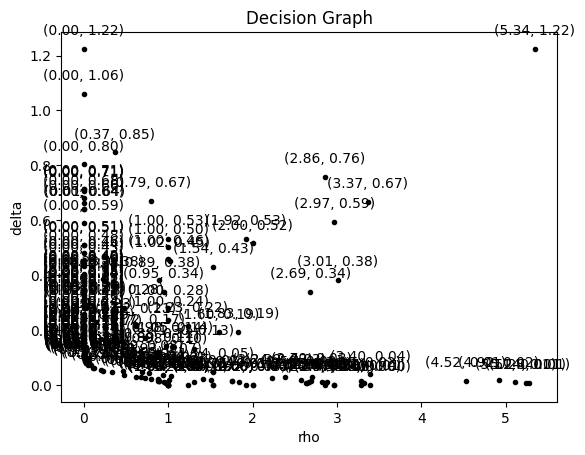

<Figure size 640x480 with 0 Axes>

In [83]:
plot(f'{CLUSTER_PATH}{CPU_ARCH}_{FAMILY}_train.dat', True)

### Cluster

In [84]:
import logging
from plot import *
from cluster import *


def plot(data, density_threshold, distance_threshold, auto_select_dc = False, family = None):
	logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
	dpcluster = DensityPeakCluster()
	rho, delta, nneigh = dpcluster.cluster(load_paperdata, data, density_threshold, distance_threshold, auto_select_dc = auto_select_dc)
	logger.info(str(len(dpcluster.ccenter)) + ' center as below')
	for idx, center in dpcluster.ccenter.items():
		logger.info('%d %f %f' %(idx, rho[center], delta[center]))
	plot_rho_delta(rho, delta)   #plot to choose the threthold
	plot_rhodelta_rho(rho,delta)
	plot_cluster(dpcluster, family)

2024-07-02 13:40:43,703 : INFO : PROGRESS: load data
2024-07-02 13:40:43,741 : INFO : PROGRESS: load end
2024-07-02 13:40:43,741 : INFO : PROGRESS: select dc
2024-07-02 13:40:43,754 : INFO : PROGRESS: compute local density
2024-07-02 13:40:43,756 : INFO : PROGRESS: at index #20
2024-07-02 13:40:43,758 : INFO : PROGRESS: at index #40
2024-07-02 13:40:43,760 : INFO : PROGRESS: at index #60
2024-07-02 13:40:43,762 : INFO : PROGRESS: at index #80
2024-07-02 13:40:43,763 : INFO : PROGRESS: at index #100
2024-07-02 13:40:43,765 : INFO : PROGRESS: at index #120
2024-07-02 13:40:43,766 : INFO : PROGRESS: at index #140
2024-07-02 13:40:43,766 : INFO : PROGRESS: at index #160
2024-07-02 13:40:43,767 : INFO : PROGRESS: at index #180
2024-07-02 13:40:43,767 : INFO : PROGRESS: compute min distance to nearest higher density neigh
2024-07-02 13:40:43,768 : INFO : PROGRESS: at index #20
2024-07-02 13:40:43,769 : INFO : PROGRESS: at index #40
2024-07-02 13:40:43,769 : INFO : PROGRESS: at index #60
2024

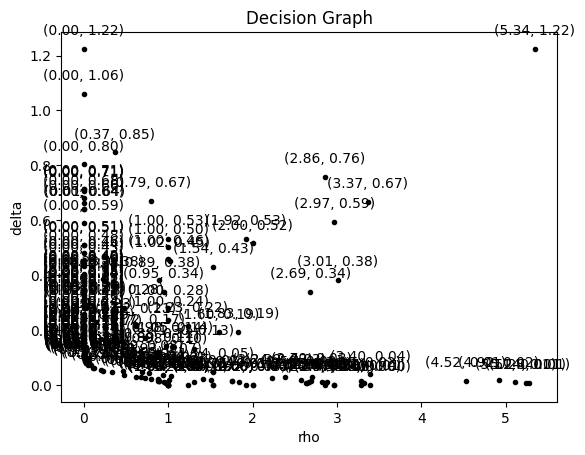

2024-07-02 13:40:44,174 : INFO : PLOT: rho*delta_rho plot


<Figure size 640x480 with 0 Axes>

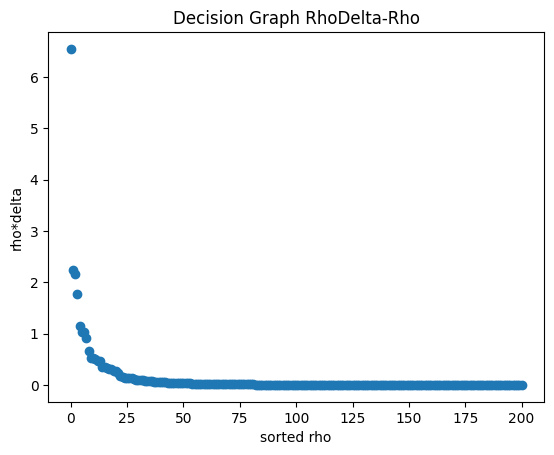

2024-07-02 13:40:44,265 : INFO : PLOT: cluster result, start multi-dimensional scaling
2024-07-02 13:40:44,372 : INFO : PLOT: end mds, start plot


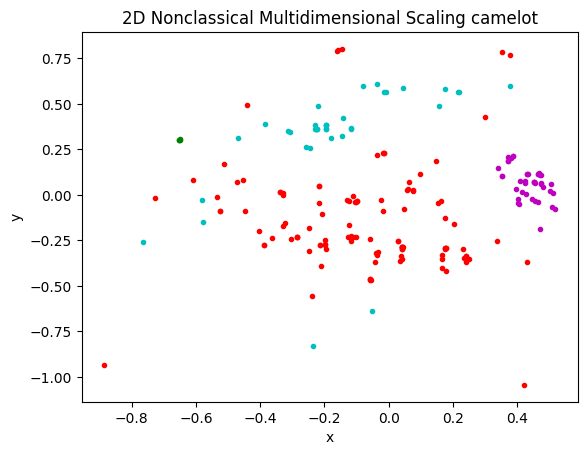

<Figure size 640x480 with 0 Axes>

In [85]:
plot(f'{CLUSTER_PATH}{CPU_ARCH}_{FAMILY}_train.dat', 2.8, 0.5, True, family = FAMILY)